In [1]:
# Importing required libraries
import re # used filter text using regular expression 
import nltk # used to natural language processing
import pickle # used load or open model

In [2]:
# Building spark session with hive context
sql_context = SparkSession.builder.appName("TwitterSentimentAnalysis").enableHiveSupport().getOrCreate()

# LOADING

In [3]:
# loading extracted data from flume using hive query
tweets = sql_context.sql("select id,text, entities.user_mentions.name from incremental_tweets")
tweets.show()

+-------------------+--------------------+--------------------+
|                 id|                text|                name|
+-------------------+--------------------+--------------------+
|1256595174651617282|RT @QOS_Clara: Iv...|             [Clara]|
|1256595174932824065|RT @bibonunes1: A...|        [Bibo Nunes]|
|1256595174945406976|RT @femingoss: a....|          [Felósofa]|
|1256595174941233153|RT @johncardillo:...|     [John Cardillo]|
|1256595174941212675|RT @BrexitHome: E...|       [Brexit Home]|
|1256595174945443841|RT @OnlyRayofHope...|[Only Ray of Hope...|
|1256595175062806530|RT @Folaszn: Awww...|      [FolaKanBai📸]|
|1256595175129985024|RT @ColourPopCo: ...|[ColourPop Cosmet...|
|1256595175234662402|@longlanguor Nnti...|          [jumaijah]|
|1256595174739894273|Los ASESORES no s...|                  []|
|1256595175171698688|RT @yogirlexy: if...|       [lexy bustos]|
|1256595175280914432|RT @vjimenezyuste...|[Víctor Jiménez Y...|
|1256595175175892992|Remember, 2 month...

Loading model for prediction

In [4]:
with open('model/logistic_model.pkl', 'rb') as file:
    bow_obj = pickle.load(file) # bow_obj is to use transform function to convert data into vector
    model = pickle.load(file) # model is used to predict sentiment

/home/ubuntu/.local/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator CountVectorizer from version 0.21.3 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/ubuntu/.local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.linear_model.logistic module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.linear_model. Anything that cannot be imported from sklearn.linear_model is now part of the private API.
  warnings.warn(message, FutureWarning)
/home/ubuntu/.local/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.21.3 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


# Transformation:

# Prediction

In [5]:
def prediction(text):
    transformed_data = bow_obj.transform([text])
    sentiment = model.predict(transformed_data)
    if 0 < sentiment:
        return 'POSITIVE'
    else:
        return 'NEGATIVE'

# Lemmatization

Lemmatization is the process of getting root word of a given word

In [6]:
def lemmatization(data):
    lemmatizer = nltk.stem.wordnet.WordNetLemmatizer()
    sentence = []
    for word in data:
        sentence.append(lemmatizer.lemmatize(word))
    return prediction(" ".join(sentence))

# Tokenizing

Tokenizing is a technique to split text into pieceses and consider each piece as token

In [7]:
def tokenizing(data):
    stop_words = set(nltk.corpus.stopwords.words('english')) # stop words are expression words to verb or noun
    tokenizer = nltk.tokenize.TweetTokenizer()
    document = []
    tokens = tokenizer.tokenize(data)
    for token in tokens:
        if token not in stop_words:
            document.append( re.sub("@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+", " ", token))
    return lemmatization(document)

Creating spark dataframe from rdd

In [8]:
sentiment_rdd = tweets.rdd.map(lambda r: (tokenizing(r.text), r.name)).flatMapValues(lambda x:x)
sentiment_df = sentiment_rdd.toDF(schema=['sentiment', 'user'])

In [9]:
sentiment_df.show()

+---------+--------------------+
|sentiment|                user|
+---------+--------------------+
| POSITIVE|               Clara|
| POSITIVE|          Bibo Nunes|
| POSITIVE|            Felósofa|
| NEGATIVE|       John Cardillo|
| POSITIVE|         Brexit Home|
| POSITIVE|    Only Ray of Hope|
| POSITIVE|     Arvind Kejriwal|
| POSITIVE|        FolaKanBai📸|
| NEGATIVE| ColourPop Cosmetics|
| POSITIVE|            jumaijah|
| POSITIVE|         lexy bustos|
| POSITIVE|Víctor Jiménez Yu...|
| POSITIVE|     Donald J. Trump|
| POSITIVE|Women's Budget Group|
| NEGATIVE|              T H M™|
| POSITIVE|  Ministry of E & IT|
| POSITIVE|Sandpiper👑✝️✡️🐕...|
| POSITIVE|Alejandro Gámez S...|
| POSITIVE|           Amanda 😷|
| POSITIVE|           Kang Away|
+---------+--------------------+
only showing top 20 rows



Converting Spark dataframe to pandas dataframe for visualization

In [10]:
pandas_df = sentiment_df.toPandas()

# Data Visualization

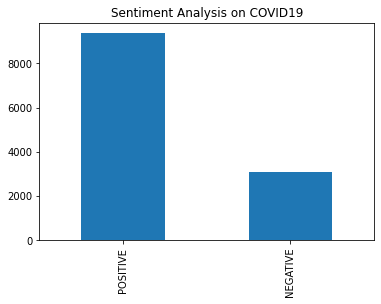

In [12]:
pandas_df['sentiment'].value_counts().plot(kind='bar', title="Sentiment Analysis on COVID19")